In [1]:
from scipy.stats import uniform
import datetime

import pandas as pd
import numpy as np

import json
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sktime.datatypes import convert_to

from sklearn.utils import class_weight


from sktime.transformations.series.exponent import ExponentTransformer, SqrtTransformer
from sktime.transformations.series.cos import CosineTransformer

from sktime.transformations.series.summarize import SummaryTransformer
from sktime.transformations.series.augmenter import WhiteNoiseAugmenter

from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Model import
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')


<span style="font-size:1.5em;">Settings and pre-execution analysis functions</span>

In [2]:
DESIGN_NAME = "FabScalar"
DESIGN = DESIGN_NAME.lower()
REPO_PATH = "/mnt/shared-scratch/Hu_J/minh.luu/github/vcdiag_fabscalar"

DATA_ANALYSIS_PATH = f"{REPO_PATH}/data_analysis"
CONFIG_PATH = f"{REPO_PATH}/configs/{DESIGN}.json"
FINAL_BUG_DATA_PATH_TRAIN = f"{DATA_ANALYSIS_PATH}/data/final_data/train/"
FINAL_BUG_DATA_PATH_TEST = f"{DATA_ANALYSIS_PATH}/data/final_data/test/"

In [3]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
sim_and_extract_config = config["sim_and_extract"]
extract_config = sim_and_extract_config["extract"]
BEFORE_FAILURE_TIMEFRAME = extract_config["line_limit"]
label_mapping = config["general"]["label_mapping"]

In [4]:
# Count the frequency of each label in the train label.csv
def count_label_frequency(label_file_path):
    label_freq = {}
    with open(label_file_path, 'r') as f:
        for line in f:
            label = line.split(',')[1].strip()
            if label not in label_freq:
                label_freq[label] = 1
            else:
                label_freq[label] += 1
    return label_freq


display(count_label_frequency(FINAL_BUG_DATA_PATH_TRAIN + "label.csv"))
display(count_label_frequency(FINAL_BUG_DATA_PATH_TEST + "label.csv"))

{'FECHONE': 744,
 'FECHWO': 774,
 'DECODE': 651,
 'DISP': 382,
 'EXEC': 630,
 'INSBUF': 450,
 'ISSUE': 460,
 'LSU': 558,
 'MAPABLE': 528,
 'REGREAD': 641,
 'REIRE': 411,
 'RENAME': 387}

{'FECHONE': 94,
 'FECHWO': 126,
 'DECODE': 120,
 'DISP': 50,
 'EXEC': 93,
 'INSBUF': 70,
 'ISSUE': 87,
 'LSU': 75,
 'MAPABLE': 91,
 'REGREAD': 113,
 'REIRE': 48,
 'RENAME': 63}

<span style="font-size:1.5em;">Support classes and functions</span>

In [5]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

<span style="font-size:1.5em;">Training</span>

<span style="font-size:1em;">Data import and preprocess</span>

In [6]:
# Read training data from csv
X_train = pd.read_csv(f"{FINAL_BUG_DATA_PATH_TRAIN}/data.csv")
label_train_df = pd.read_csv(
    f"{FINAL_BUG_DATA_PATH_TRAIN}/label.csv", index_col=0, header=None)
y_train = label_train_df.to_numpy().flatten()

# Read testing data from csv
X_test = pd.read_csv(f"{FINAL_BUG_DATA_PATH_TEST}/data.csv")

label_test_df = pd.read_csv(
    f"{FINAL_BUG_DATA_PATH_TEST}/label.csv", index_col=0, header=None)
y_test = label_test_df.to_numpy().flatten()

# Drop column "instances" for both training and testing data
X_train = X_train.drop(columns=["instances"])
X_test = X_test.drop(columns=["instances"])

X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = label_train_df.to_numpy().flatten()
y_test_original = label_test_df.to_numpy().flatten()

In [7]:
X_train = X_train_original.copy()
X_test = X_test_original.copy()
y_train = y_train_original.copy()
y_test = y_test_original.copy()

print(f"Label mapping: {label_mapping}")

# Convert the labels to the corresponding values in the label_mapping
for i in range(len(y_train)):
    y_train[i] = label_mapping[y_train[i]]
for i in range(len(y_test)):
    y_test[i] = label_mapping[y_test[i]]

# cap the training dataset at 200 samples per class
X_train = X_train.copy()
y_train = y_train.copy()
X_train["label"] = y_train
X_train = X_train.groupby("label").head(3000)
y_train = X_train["label"]
X_train = X_train.drop(columns=["label"])

label_freq_train = {}
for label in y_train:
    if label not in label_freq_train:
        label_freq_train[label] = 1
    else:
        label_freq_train[label] += 1
        
label_freq_test = {}
for label in y_test:
    if label not in label_freq_test:
        label_freq_test[label] = 1
    else:
        label_freq_test[label] += 1
       
display(label_freq_train)
display(label_freq_test)

Label mapping: {'FECHONE': 'FetchStage1', 'FECHWO': 'FetchStage2', 'DECODE': 'Decode', 'INSBUF': 'InstructionBuffer', 'RENAME': 'Rename', 'DISP': 'Dispatch', 'ISSUE': 'IssueQueue', 'REGREAD': 'RegRead', 'EXEC': 'Execution', 'LSU': 'LoadStoreUnit', 'REIRE': 'Retire', 'MAPABLE': 'ArchMapTable'}


{'FetchStage1': 744,
 'FetchStage2': 774,
 'Decode': 651,
 'Dispatch': 382,
 'Execution': 630,
 'InstructionBuffer': 450,
 'IssueQueue': 460,
 'LoadStoreUnit': 558,
 'ArchMapTable': 528,
 'RegRead': 641,
 'Retire': 411,
 'Rename': 387}

{'FetchStage1': 94,
 'FetchStage2': 126,
 'Decode': 120,
 'Dispatch': 50,
 'Execution': 93,
 'InstructionBuffer': 70,
 'IssueQueue': 87,
 'LoadStoreUnit': 75,
 'ArchMapTable': 91,
 'RegRead': 113,
 'Retire': 48,
 'Rename': 63}

In [8]:
# convert all labels to float
le = LabelEncoder()
y_train_float = le.fit_transform(y_train)
y_test_float = le.transform(y_test)

# prep stats
classes = np.unique(y_train_float)
n_classes = len(classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_float
)

display(f"Weights: {class_weights}")
class_weights = {i: class_weights[i] for i in range(n_classes)}
max_delta_step = 1

'Weights: [1.04419192 0.8469022  1.44328098 0.87513228 0.74103943 0.71231697\n 1.22518519 1.19855072 0.98805257 0.8601144  1.42463394 1.34144363]'

In [9]:
columns_to_drop = [name for name in X_train.columns if any([name.endswith(suffix) for suffix in ["_kurt"]])]

X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [10]:
display(X_train.head())
display(X_train.shape)
display(y_train)

,1__0.1,1__0.5,1__0.9,1__0.25,1__0.75,1__max,1__mean,1__min,1__std,2__0.1,...,4860__std,4861__0.1,4861__0.5,4861__0.9,4861__0.25,4861__0.75,4861__max,4861__mean,4861__min,4861__std
0,120.0,1000.0,1880.0,450.0,1550.0,2100.0,1005.111111,0.0,648.535491,1.0,...,24.784791,34.0,34.0,34.0,34.0,34.0,120.0,37.822222,34.0,17.923181
1,440.0,2600.0,4760.0,1250.0,3950.0,5300.0,2602.110092,0.0,1576.949160,1.0,...,16.409773,34.0,34.0,34.0,34.0,34.0,120.0,35.577982,34.0,11.595253
2,94.0,850.0,1610.0,375.0,1325.0,1800.0,855.897436,0.0,560.782902,1.0,...,26.591248,34.0,34.0,34.0,34.0,34.0,120.0,38.410256,34.0,19.217204
3,130.0,1050.0,1970.0,475.0,1625.0,2200.0,1054.893617,0.0,677.725969,1.0,...,24.279535,34.0,34.0,34.0,34.0,34.0,120.0,37.659574,34.0,17.546555
4,76.0,700.0,1340.0,300.0,1100.0,1500.0,706.969697,0.0,472.655298,1.0,...,28.834395,34.0,34.0,34.0,34.0,34.0,120.0,39.212121,34.0,20.838302


(6616, 43749)

0       FetchStage1
1       FetchStage1
2       FetchStage1
3       FetchStage1
4       FetchStage1
           ...     
6611         Rename
6612         Rename
6613         Rename
6614         Rename
6615         Rename
Name: label, Length: 6616, dtype: object

<span style="font-size:1em;">ML model definition and training</span>

In [11]:
# Define the RF parameters
rf_params = {
    'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False, 'class_weight': class_weights
}

model = RandomForestClassifier(**rf_params)

print(model)

model.fit(X_train, y_train_float)

RandomForestClassifier(bootstrap=False,
                       class_weight={0: np.float64(1.0441919191919191),
                                     1: np.float64(0.8469022017409115),
                                     2: np.float64(1.443280977312391),
                                     3: np.float64(0.8751322751322751),
                                     4: np.float64(0.7410394265232975),
                                     5: np.float64(0.7123169681309216),
                                     6: np.float64(1.2251851851851852),
                                     7: np.float64(1.1985507246376812),
                                     8: np.float64(0.98805256869773),
                                     9: np.float64(0.860114404576183),
                                     10: np.float64(1.4246339362618432),
                                     11: np.float64(1.3414436334144364)},
                       max_depth=50, min_samples_split=10, n_estimators=50)


RandomForestClassifier(bootstrap=False,
                       class_weight={0: np.float64(1.0441919191919191),
                                     1: np.float64(0.8469022017409115),
                                     2: np.float64(1.443280977312391),
                                     3: np.float64(0.8751322751322751),
                                     4: np.float64(0.7410394265232975),
                                     5: np.float64(0.7123169681309216),
                                     6: np.float64(1.2251851851851852),
                                     7: np.float64(1.1985507246376812),
                                     8: np.float64(0.98805256869773),
                                     9: np.float64(0.860114404576183),
                                     10: np.float64(1.4246339362618432),
                                     11: np.float64(1.3414436334144364)},
                       max_depth=50, min_samples_split=10, n_estimators=50)

<span style="font-size:1.5em;">Testing</span>

In [12]:
y_pred_bin = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_bin)
y_pred_proba = model.predict_proba(X_test)

0.7116504854368932
0.858252427184466


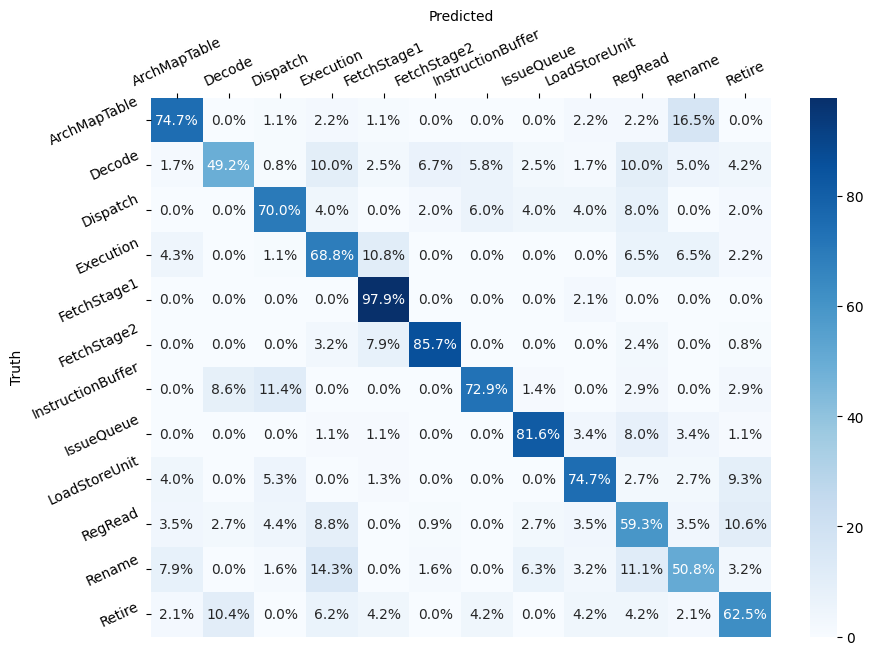

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, top_k_accuracy_score

acs = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cr = classification_report(y_test, y_pred, digits=4, output_dict=True)
top3_acs = top_k_accuracy_score(y_test, y_pred_proba, k=3 if n_classes > 3 else n_classes)

print(acs)
print(top3_acs)

# Convert integer labels for the confusion matrix to string labels
labels = np.unique(y_train)

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt=".1f", cmap='Blues',
                 xticklabels=labels, yticklabels=labels)
# Add % sign to heatmap
for t in ax.texts:
    t.set_text(t.get_text() + "%")
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', rotation=25)

ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.tick_params(axis='y', rotation=25)


# Save the confusion matrix and classification report to a file
# Create a folder to store the logs if it does not exist
if not os.path.exists(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs"):
    os.makedirs(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs")
plt.savefig(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/cm_rfc_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png", bbox_inches='tight', dpi=150)
# round to 4 decimal places for better readability
cr_df = pd.DataFrame(cr).transpose().round(4)
cr_df.to_csv(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/cr_rfc_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv")

In [14]:
# Create a DataFrame to display the probabilities in a more descriptive way
df_prob = pd.DataFrame(y_pred_proba, columns=[f'{class_name}_prob' for class_name in le.classes_])
df_prob['True_Label'] = y_test
df_prob['Predicted_Label'] = y_pred

# Inverse transform the labels
# df_prob['True_Label'] = le.inverse_transform(df_prob['True_Label'])
# df_prob['Predicted_Label'] = le.inverse_transform(df_prob['Predicted_Label'])

# Show only misclassified instances
df_prob = df_prob[df_prob['True_Label'] != df_prob['Predicted_Label']]

# Print the entire DataFrame
pd.set_option('display.max_rows', None)
display(df_prob)

,ArchMapTable_prob,Decode_prob,Dispatch_prob,Execution_prob,FetchStage1_prob,FetchStage2_prob,InstructionBuffer_prob,IssueQueue_prob,LoadStoreUnit_prob,RegRead_prob,Rename_prob,Retire_prob,True_Label,Predicted_Label
1,0.000000,0.036148,0.059281,0.075702,0.209700,0.063955,0.000000,0.018003,0.329018,0.081529,0.087049,0.039615,FetchStage1,LoadStoreUnit
92,0.028907,0.015240,0.086596,0.137496,0.053899,0.076639,0.016490,0.079285,0.277023,0.022741,0.190142,0.015543,FetchStage1,LoadStoreUnit
102,0.000000,0.000000,0.000000,0.000000,0.605747,0.360000,0.034253,0.000000,0.000000,0.000000,0.000000,0.000000,FetchStage2,FetchStage1
106,0.025429,0.006345,0.015783,0.548186,0.004629,0.045103,0.054052,0.003937,0.000906,0.265469,0.007078,0.023083,FetchStage2,Execution
112,0.025429,0.006345,0.015783,0.548186,0.004629,0.045103,0.054052,0.003937,0.000906,0.265469,0.007078,0.023083,FetchStage2,Execution
113,0.000000,0.000000,0.000000,0.020000,0.495415,0.413156,0.060000,0.000000,0.011429,0.000000,0.000000,0.000000,FetchStage2,FetchStage1
114,0.000000,0.000000,0.000000,0.000000,0.749050,0.250950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,FetchStage2,FetchStage1
117,0.000000,0.000000,0.000000,0.020000,0.475415,0.433156,0.060000,0.000000,0.011429,0.000000,0.000000,0.000000,FetchStage2,FetchStage1
150,0.000000,0.000000,0.053297,0.015930,0.040000,0.408378,0.000000,0.002523,0.052444,0.415583,0.000000,0.011845,FetchStage2,RegRead
166,0.000113,0.031960,0.044984,0.542639,0.020280,0.040922,0.010457,0.001228,0.000906,0.297426,0.007078,0.002007,FetchStage2,Execution


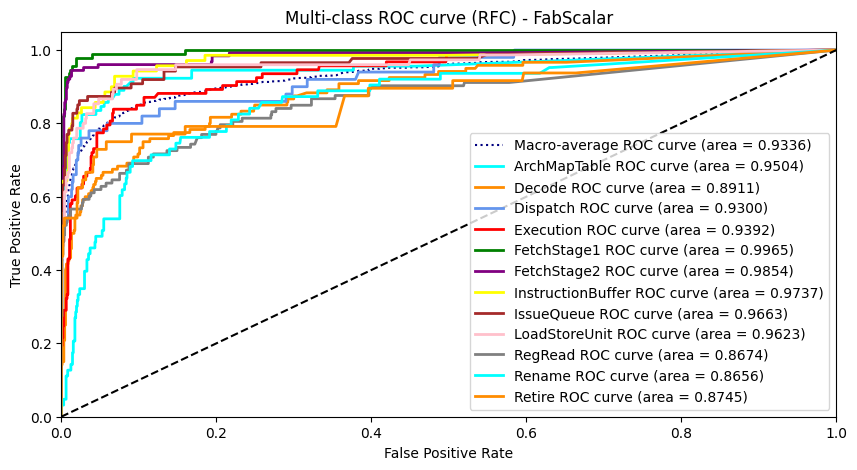

In [16]:
# Graph multi-class ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

n_classes = len(count_label_frequency(FINAL_BUG_DATA_PATH_TRAIN + "label.csv"))
class_names = le.classes_
y_test_bin = label_binarize(y_test, classes=class_names)
y_pred_bin = y_pred_proba

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 5))
plt.plot(fpr["macro"], tpr["macro"], label="Macro-average ROC curve (area = {:.4f})".format(roc_auc["macro"]), color="navy", linestyle=":")
colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "purple", "yellow", "brown", "pink", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label="{0} ROC curve (area = {1:.4f})".format(class_names[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multi-class ROC curve (RFC) - {DESIGN_NAME}")
plt.legend(loc="lower right")

# Save the ROC curve
plt.savefig(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/roc_rfc_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png", bbox_inches='tight', dpi=150)

plt.show()